# 09-PSF_Phot

Here I benchmarked the DAOPHOT (originally called DAOPHOT II) by P. B. Stetson, which is implemented to [IRAF's psf noao.digiphot.daophot](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?psf).

In [5]:
from pathlib import Path
import numpy as np

from astropy.io import fits

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup
from photutils.psf import FittableImageModel

from scipy.interpolate import RectBivariateSpline

from matplotlib import pyplot as plt
from matplotlib import rcParams

from astropy.stats import sigma_clipped_stats
from astropy.nddata import CCDData, Cutout2D
from astropy.table import Table, vstack
from astropy.modeling.fitting import LevMarLSQFitter

import ysfitsutilpy as yfu
import ysphotutilpy as ypu
import ysvisutilpy as yvu

plt.style.use('default')
rcParams.update({'font.size':12})

PSFPATH = Path("tmp/psf_01.fits")
PHOTPSFPATH = Path("tmp/psf_01.csv")
DATAPATH = Path("tmp/SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR.fits")
FITTER = LevMarLSQFitter()

phot_psf = Table.read(PHOTPSFPATH)
psfccd = yfu.load_ccd(PSFPATH)
psfhdr = psfccd.header
PSF_OVERSAMPLE = psfhdr["OVERSAMP"]
psf_init = FittableImageModel(data=psfccd.data,
                              oversampling=PSF_OVERSAMPLE,
                              normalize=True,
                              ikwargs={"degree":[3, 3], "s":0})

fwhm = psfhdr["FWHM"]
psf_size = psfhdr["PSFSIZE"]
r_fit = fwhm # max(2, min(fwhm, 5))

ccd = yfu.load_ccd(DATAPATH)
hdr = ccd.header
err = yfu.make_errmap(ccd=ccd, gain_epadu=hdr["GAIN"], rdnoise_electron=hdr["RDNOISE"])
data = ccd.data

ccd.uncertainty = err

INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


## Test Initial PSF Stars

In [6]:
cuts = dict(cut=[], err=[], fit=[])


for row in phot_psf:
    pos = (row["xcentroid"], row["ycentroid"])        
#     pos_cut = cut.to_cutout_position(pos)
    scut = Cutout2D(data, position=pos, size=3 * psf_size)  # "subtraction" cut

    result = ypu.dao_nstar(data=scut.data, 
                           position=scut.to_cutout_position(pos), 
                           r_fit=r_fit, 
                           psf=psf_init,
                           flux_init=row["source_sum"], 
                           sky=row["msky"], 
                           err=err, 
                           full=True)
    fit, pos_fit, fitter, astropy_weight, fcut, fcut_skysub, fcut_err = result

    yy_sub, xx_sub = np.mgrid[:scut.data.shape[1], :scut.data.shape[0]]
    star = fit(xx_sub, yy_sub)
    
    cuts["cut"].append(scut)
    cuts["err"].append(fcut_err)
    cuts["fit"].append(star)

cuts_tab = Table(cuts)

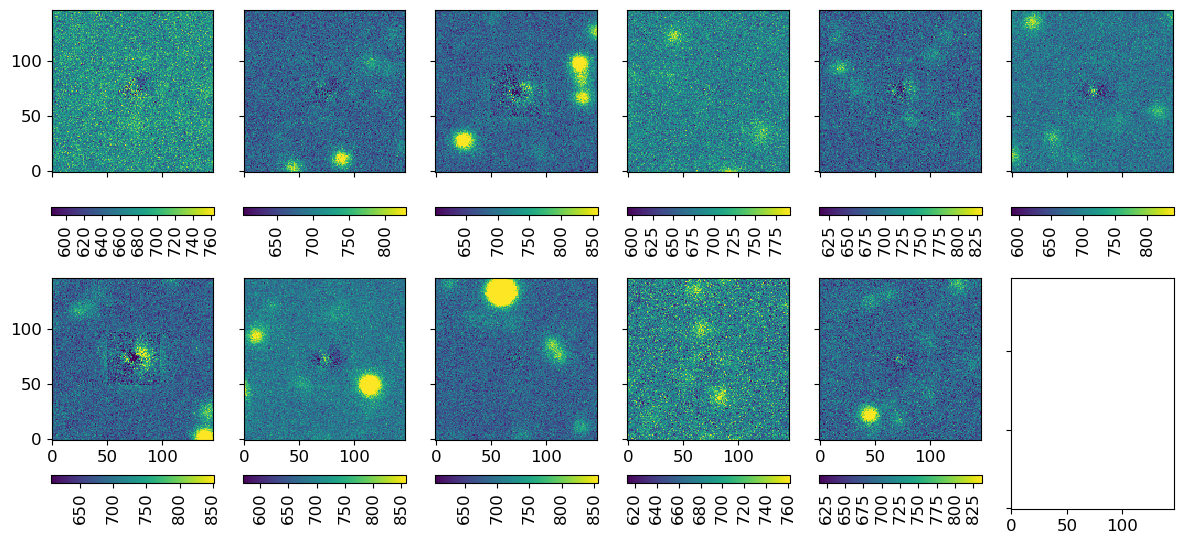

In [8]:
ncol = 6
nrow = max(len(cuts_tab) // ncol + 1, 1)
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 2.8 * nrow), sharex=True, sharey=True)

for i, row in enumerate(cuts_tab):
    # Figure plotting
    irow = i // ncol
    icol = i - irow * ncol
    ax = axs[irow, icol]
#     posstr = f"({row['xcentroid']:.1f}, {row['ycentroid']:.1f})"
    
    # For showing bright star for PSF, it's better to set high vmin, not zscale,
    # because the central structure near the star cneter is important.
    im = yvu.norm_imshow(ax, row["cut"].data - row["fit"], zscale=True)
    cb = yvu.colorbaring(fig, ax, im)
    plt.setp(cb.ax.get_xticklabels(),rotation=90)
    
plt.tight_layout()


Although not perfectly satisfactory, I will proceed the PSF photometry using this initial PSF. If you want better results, you should do the following:

1. For each PSF stars above, you may see some nearby stars after this initial star subtraction. 
2. Using our initial PSF (say PSF_01), fit PSF_01 to the nearby fainter stars.
3. Subtract the fitted profile.
4. Use this nearby-star-subtracted image to get the PSF as we did in the previous notebook.
5. Get PSF_02
6. Redo these until you are satisfied.

(same as [IRAF psf](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?psf))

Although PSF_01 will be different from the true PSF (PSF_0), the difference (PSF_0 - PSF_01) will be large only at the wing part, not the core part. The stars nearby our PSF stars must be much fainter than our PSF stars, and thus the contribution of their wing must be small compared to the PSF stars' core parts. This is why we can proceed the iteration by subtracting the nearby star using PSF_01, not PSF_0. 

```python
################# FOR TEST #################
ccd = CCDData(data=ccd.data[1000:2000,1000:2000],#[2000:3000,2000:3000], ################# FOR TEST #################
              uncertainty=err[1000:2000,1000:2000],#[2000:3000,2000:3000], ################# FOR TEST #################
              header=ccd.header, unit='adu')

ccd.data = np.pad(ccd.data, pad_width=psf_size//2, mode='constant',
                  constant_values=np.nan)
ccd.uncertainty.array = np.pad(ccd.uncertainty.array, pad_width=psf_size//2, mode='constant',
                               constant_values=np.nan)
############################################
```

In [9]:
err = yfu.make_errmap(ccd=ccd, gain_epadu=hdr["GAIN"], rdnoise_electron=hdr["RDNOISE"])
data = ccd.data

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=10, std_ddof=1)
threshold = med - 5 * std
print(avg, med, std, threshold)

finder = DAOStarFinder(fwhm=fwhm, threshold=threshold,
                       sharplo=0., sharphi=2.0,   # default values 0.2 and 1.0
                       roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                       sigma_radius=2.5,           # default values 1.5
                       ratio=1.0,                  # 1.0: circular gaussian
                       exclude_border=True)        # To exclude sources near edges

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = finder(data)

# Select only the stars NOT at the edges (bezel) of the image
found = found[(found["xcentroid"] > psf_size)
             & (found["xcentroid"] < ccd.header["NAXIS1"] - psf_size)
             & (found["ycentroid"] > psf_size)
             & (found["ycentroid"] < ccd.header["NAXIS2"] - psf_size)]

# This needs to be updated by photutils....
found["id"] = np.arange(len(found)) + 1  

star_groups = ypu.group_stars(table=found,
                              crit_separation=2.8 * fwhm, 
                              xcol="xcentroid",
                              ycol="ycentroid",
                              index_only=False)

684.0113 683.18945 26.844547 548.9667167663574


* **QUESTION**: See what error you will get if you comment out the line ``found["id"] = np.arange(len(found)) + 1``.

1344 star groups out of 1653 stars


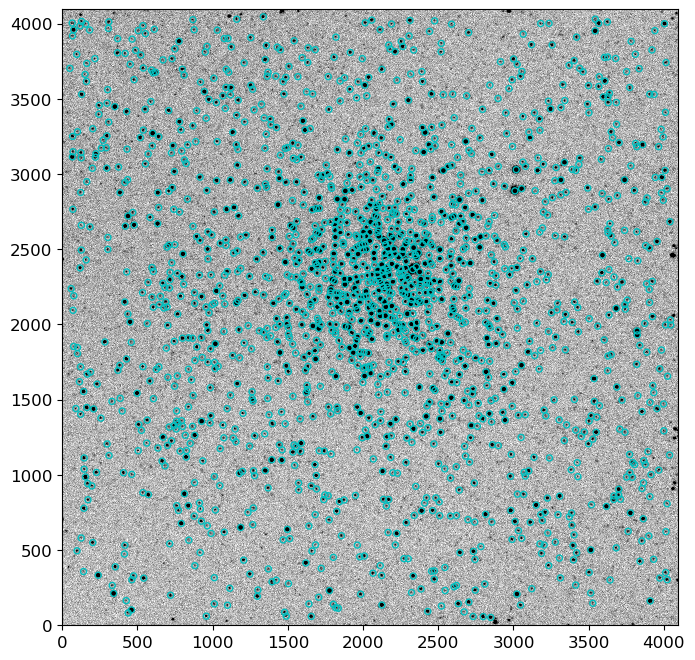

<Figure size 640x480 with 0 Axes>

In [12]:
coords_SF = (found['xcentroid'], found['ycentroid'])
ap_found = CAp(coords_SF, r=25) 

print(f"{len(star_groups.groups)} star groups out of {len(star_groups)} stars")

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False, gridspec_kw=None)
yvu.norm_imshow(axs, data, cmap="gray_r", zscale=True)

for i, group in enumerate(star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CAp(xypos, r=20)
    ap.plot(color='c', lw=1)
plt.show()

plt.tight_layout()

In [13]:
r_fit = 5 # max(2, min(fwhm, 5))
fbox = 2 * r_fit + 1 # fitting box size
r_in = 4 * fwhm
r_out = 6 * fwhm

xypos = np.transpose([star_groups['x_0'], star_groups['y_0']])
ap = CAp(xypos, r=r_fit)
an = CAn(xypos, r_in=r_in, r_out=r_out)
phot = ypu.apphot_annulus(ccd, aperture=ap, annulus=an, error=err,
                          sky_keys={"mode_option":"MMM"})
phot["group_id"] = star_groups["group_id"]
phot = Table(phot)

In [14]:
phot

<Table length=1653>
  id       xcenter            ycenter       ...          merr         group_id
             pix                pix         ...                               
int64      float64            float64       ...        float64         int64  
----- ------------------ ------------------ ... --------------------- --------
    1  2848.957456377571  51.56822969127648 ...  0.010150587118078227        1
    2 2798.7993033084576  56.98446334368872 ...  0.008573212693618439        2
    3  2731.699861723366  57.75837027679825 ...  0.026207820617202927        3
    4 1655.3184997497005 58.347353068201656 ...  0.008093207988482272        4
    5  957.9874802636899  60.14492490191232 ...    0.0215499851619153        5
    6 1489.0702514640313  60.47337491248807 ...   0.02371243921674443        6
    7 1478.1523822215881  86.09008982449117 ...  0.026840871055317905        6
    8  438.0290146914016  81.55705083352616 ...   0.02734977364172932        7
    9 459.91412506091757 101.69444567358809 ... 0.0024016643367377696        7
  ...                ...                ... ...                   ...      ...
 1644  2014.003577521524 4005.5544789508767 ...  0.016955706238521814     1335
 1645 3624.3110072668815 4011.0366816394026 ...  0.024967625135663488     1336
 1646  309.5077911532157  4011.693246988663 ...  0.019231691729677543     1337
 1647 2475.6005235066923  4018.428855622228 ...    0.0426528884076714     1338
 1648 2312.1505991588324  4021.344364737239 ...  0.010413706125160132     1339
 1649 2057.8912874862303     4023.617933439 ...  0.012984666515256049     1340
 1650  868.2781544860879 4026.3391957975673 ...   0.03754981439070742     1341
 1651 1159.8182526884164 4029.0905145688225 ...  0.024219821494477187     1342
 1652  3544.012226944256 4029.9959841160176 ...  0.044842292099159714     1343
 1653  1336.960217487264  4045.337174689975 ...  0.017033920659007915     1344

### Extract Using PSF

In [15]:
from IPython.display import clear_output

stars_01 = dict(id=[], group_id=[], x=[], y=[], flux=[])
data_staronly = np.zeros_like(data)
xx_all, yy_all = np.mgrid[:data_staronly.shape[1], :data_staronly.shape[0]]

phot_g = phot.group_by("group_id")
for i, group in enumerate(phot_g):
    clear_output(wait = True)
    if i % 10 == 0:
        print(f"PSF... {i} ~ {i + 10} / {len(phot_g)}")
    
    group = Table(group)
    sky = np.mean(group["msky"])  # use avg sky; see comment below.
    for row in group:
        pos_init = np.transpose([row["xcenter"], row["ycenter"]])
        result = ypu.dao_nstar(data=data, position=pos_init, r_fit=r_fit, psf=psf_init,
                               flux_init=row["source_sum"], sky=sky, err=err, full=True)
        fit, pos_fit, fitter, astropy_weight, fcut, fcut_skysub, fcut_err = result
        stars_01["id"].append(row["id"])
        stars_01["group_id"].append(row["group_id"])
        stars_01["x"].append(pos_fit[0])
        stars_01["y"].append(pos_fit[1])
        stars_01["flux"].append(fit.flux.value)
        
        scut = Cutout2D(data, position=pos_fit, size=psf_size, mode='partial')  # "subtraction" cut
        fit.x_0, fit.y_0 = scut.to_cutout_position(pos_fit)
        
        yy_sub, xx_sub = np.mgrid[:psf_size, :psf_size]
        star = fit(xx_sub, yy_sub)
        data_staronly[scut.slices_original] += star

In [16]:
stars_01_tab = Table(stars_01)
stars_01_tab.write("tmp/psfphot_01.csv")
stars_01_tab

<Table length=1653>
  id  group_id         x                  y                 flux       
int64  int64        float64            float64            float64      
----- -------- ------------------ ------------------ ------------------
    1        1  2849.297506451822 51.823015172669976   2109191.51795056
    2        2 2798.9748694463497  57.28468422595733 2484790.2516909754
    3        3 2731.9308223120634  58.15919208297545  736073.1697290811
    4        4 1655.5712800241772  58.84693164605968 2540779.4482916626
    5        5  958.1639895499868  60.65954774669374  862533.4278657988
    6        6 1489.4782412425504 60.929989638443914   785434.321833508
    7        6 1478.2405441539697   86.8232477290606  671853.9368906507
    8        7  438.0677442872557  81.79590674921596  671980.0384822179
    9        7 460.10535518226726 102.21659111549295 12342117.618629303
   10        8  2672.437989229567  88.57858194500109  336964.4307582925
  ...      ...                ...                ...                ...
 1644     1335 2014.2633883769947 4006.0323619035535  1145299.803494963
 1645     1336 3624.4292988119596 4011.6479934930067  769470.9980124721
 1646     1337  309.5219812138997  4012.246223616505 1030129.1057330663
 1647     1338  2475.572483274304 4018.5399658228453  428220.2068072781
 1648     1339 2312.4506711868885 4021.8717156150256 1913643.9265148675
 1649     1340 2057.9418411984757 4023.9334524306455  1537012.945827284
 1650     1341  868.4085457757366 4027.1433606322394 508457.52888649656
 1651     1342 1159.8191244229126  4029.456672096729  794021.3674600084
 1652     1343 3544.0443066806874 4030.5683221276495  427572.5666798682
 1653     1344 1337.1180239286236 4045.8639440112725 1135879.5131312716

### Investigate Substar

70964.95830893912

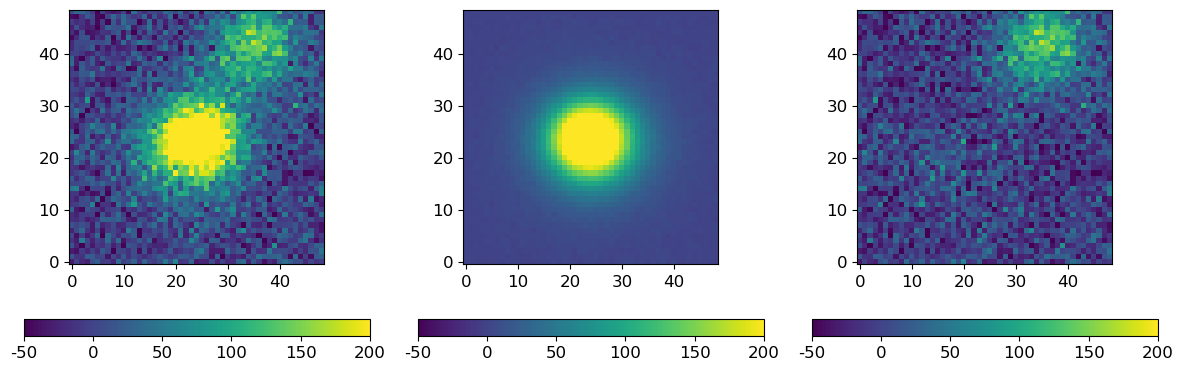

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False, gridspec_kw=None)
vv = dict(vmin=-50, vmax=200)
im = yvu.norm_imshow(axs[0], (scut.data - sky), **vv)
yvu.colorbaring(fig, axs[0], im)
im = yvu.norm_imshow(axs[1], fit(xx_sub, yy_sub), **vv)
yvu.colorbaring(fig, axs[1], im)
im = yvu.norm_imshow(axs[2], scut.data - sky - fit(xx_sub, yy_sub), **vv)
yvu.colorbaring(fig, axs[2], im)

plt.tight_layout()

np.sum(fit(xx_sub, yy_sub))


Stetson 1987 PASP 99 191 p.206:
> Thus it is clear that, for these frames at least, solving explicitly for the local diffuse sky brightness produces consistently more photometric scatter at the cost of greater effort than simply adopting the modal value found in a surrounding annulus of pixels, even though the latter method is fundamentally wrong.

For IRAF implementation:
* [psf](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?psf): manual of "how to psf"
* [daopars](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?daopars): weighting function implementation


Text(0.5, 1, 'Original')

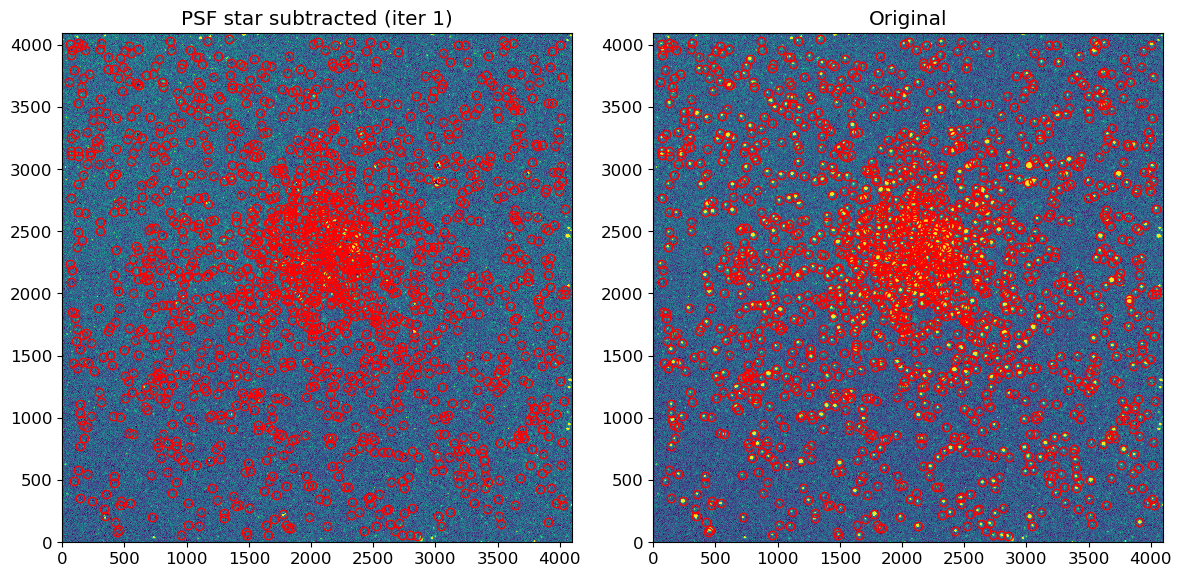

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.norm_imshow(axs[0], data - data_staronly, zscale=True)
yvu.norm_imshow(axs[1], data, zscale=True)
# axs[1].imshow(data / (data - data_staronly), vmin=-2, vmax=+2)
axs[0].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
axs[1].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
plt.tight_layout()

axs[0].set_title("PSF star subtracted (iter 1)")
axs[1].set_title("Original")

### Test Plot for a Star

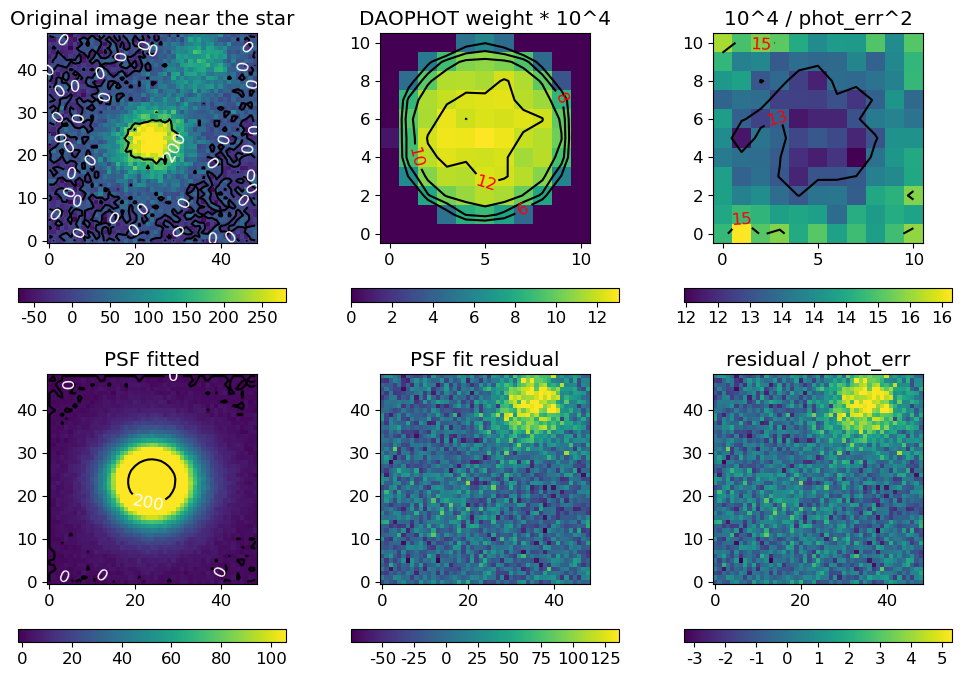

In [26]:
model_fitted = fit(xx_sub, yy_sub)
scut_skysub = scut.data - sky
scut_err = Cutout2D(err, position=pos_fit, size=psf_size).data
residual = scut_skysub - model_fitted

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=False, sharey=False, gridspec_kw=None)
axo = axs[0, 0]  # original
axd = axs[0, 1]  # DAOphot weight
d = 1.e+4 * astropy_weight**2
axp = axs[0, 2]  # phot error
p = 1.e+4 / fcut_err**2
axf = axs[1, 0]  # fit
axr = axs[1, 1]  # residual
ax1 = axs[1, 2]  # residual / phot err

im = yvu.norm_imshow(axo, scut_skysub, zscale=True)
cs = axo.contour(scut_skysub, colors='k', levels=np.arange(0, 1000, 200))
axo.clabel(cs, inline=1, colors='w', fmt="%.0f")
axo.set_title("Original image near the star")
yvu.colorbaring(fig, axo, im)

im = yvu.norm_imshow(axd, d, zscale=True)
cs = axd.contour(d, colors='k', levels=np.arange(d.max() - 7, d.max()+3, 2))
axd.clabel(cs, inline=1, colors='r', fmt="%.0f")
axd.set_title("DAOPHOT weight * 10^4")
yvu.colorbaring(fig, axd, im)

im = yvu.norm_imshow(axp, p, zscale=True)
cs = axp.contour(p, colors='k', levels=np.arange(p.max() - 7, p.max()+3, 2))
axp.clabel(cs, inline=1, colors='r', fmt="%.0f")
axp.set_title("10^4 / phot_err^2")
yvu.colorbaring(fig, axp, im)

im = yvu.norm_imshow(axf, model_fitted, zscale=True)
cs = axf.contour(model_fitted, colors='k', levels=np.arange(0, 1000, 200))
axf.clabel(cs, inline=1, colors='w', fmt="%.0f")
axf.set_title("PSF fitted")
yvu.colorbaring(fig, axf, im)

im = yvu.norm_imshow(axr, residual, zscale=True)
axr.set_title("PSF fit residual")
yvu.colorbaring(fig, axr, im)

im = yvu.norm_imshow(ax1, residual / scut_err, zscale=True)
ax1.set_title("residual / phot_err")
yvu.colorbaring(fig, ax1, im)

plt.tight_layout()

### Save

In [27]:
ccd_1 = ccd.copy()
ccd_1.data = data - data_staronly
ccd_1.uncertainty = None
ccd_1.header["PSFITER"] = 1
ccd_1 = yfu.CCDData_astype(ccd=ccd_1, dtype='float32')
ccd_1.write("tmp/SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR_PSF_01.fits", overwrite=True)

## 2nd Iteration

654.381103515625 681.8021240234375 38.22334289550781 490.68540954589844
323 star groups out of 387 stars


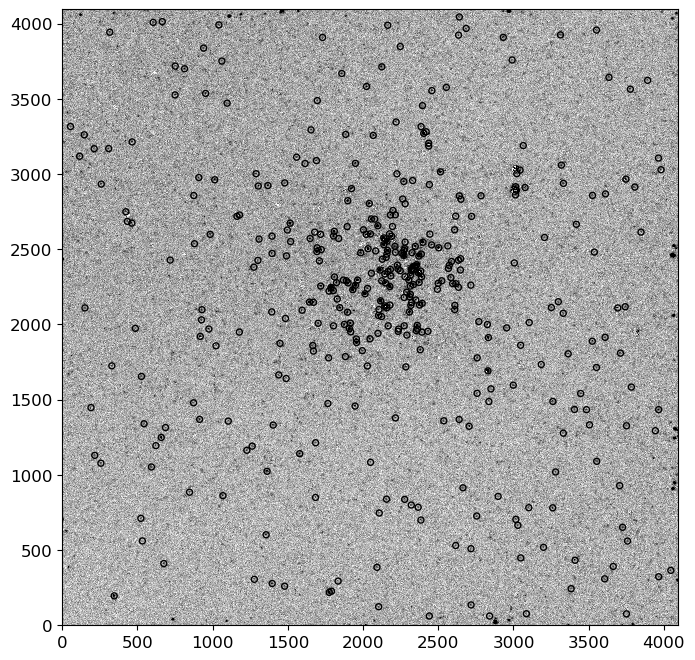

<Figure size 640x480 with 0 Axes>

In [29]:
data = ccd_1.data

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=10, std_ddof=1)
threshold = med - 5 * std
print(avg, med, std, threshold)

finder = DAOStarFinder(fwhm=fwhm, threshold=threshold,
                       sharplo=0., sharphi=2.0,   # default values 0.2 and 1.0
                       roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                       sigma_radius=2.5,           # default values 1.5
                       ratio=1.0,                  # 1.0: circular gaussian
                       exclude_border=True)        # To exclude sources near edges

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = finder(data)

# Select only the stars NOT at the edges (bezel) of the image
found = found[(found["xcentroid"] > psf_size)
             & (found["xcentroid"] < ccd.header["NAXIS1"] - psf_size)
             & (found["ycentroid"] > psf_size)
             & (found["ycentroid"] < ccd.header["NAXIS2"] - psf_size)]

# This needs to be updated by photutils....
found["id"] = np.arange(len(found)) + 1  

star_groups = ypu.group_stars(table=found,
                              crit_separation=2.8 * fwhm, 
                              xcol="xcentroid",
                              ycol="ycentroid",
                              index_only=False)

coords_SF = (found['xcentroid'], found['ycentroid'])
ap_found = CAp(coords_SF, r=25) 

print(f"{len(star_groups.groups)} star groups out of {len(star_groups)} stars")

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False, gridspec_kw=None)
yvu.norm_imshow(axs, data, cmap="gray_r", zscale=True)

for i, group in enumerate(star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    ap = CAp(xypos, r=20)
    ap.plot(lw=1)
plt.show()

plt.tight_layout()

In [30]:
xypos = np.transpose([star_groups['x_0'], star_groups['y_0']])
ap = CAp(xypos, r=r_fit)
an = CAn(xypos, r_in=r_in, r_out=r_out)
phot = ypu.apphot_annulus(ccd, aperture=ap, annulus=an, error=err,
                          sky_keys={"mode_option":"MMM"})
phot["group_id"] = star_groups["group_id"]
phot = Table(phot)

stars_02 = dict(id=[], group_id=[], x=[], y=[], flux=[])
data_staronly = np.zeros_like(data)
xx_all, yy_all = np.mgrid[:data_staronly.shape[1], :data_staronly.shape[0]]

phot_g = phot.group_by("group_id")
for i, group in enumerate(phot_g):
    clear_output(wait = True)
    if i % 10 == 0:
        print(f"PSF... {i} ~ {i + 10} / {len(phot_g)}")
    
    group = Table(group)
    sky = np.mean(group["msky"])  # use avg sky; see comment below.
    for row in group:
        pos_init = np.transpose([row["xcenter"], row["ycenter"]])
        result = ypu.dao_nstar(data=data, position=pos_init, r_fit=r_fit, psf=psf_init,
                               flux_init=row["source_sum"], sky=sky, err=err, full=True)
        fit, pos_fit, fitter, astropy_weight, fcut, fcut_skysub, fcut_err = result
        stars_02["id"].append(row["id"])
        stars_02["group_id"].append(row["group_id"])
        stars_02["x"].append(pos_fit[0])
        stars_02["y"].append(pos_fit[1])
        stars_02["flux"].append(fit.flux.value)
        
        scut = Cutout2D(data, position=pos_fit, size=psf_size, mode='partial')  # "subtraction" cut
        fit.x_0, fit.y_0 = scut.to_cutout_position(pos_fit)
        
        yy_sub, xx_sub = np.mgrid[:psf_size, :psf_size]
        star = fit(xx_sub, yy_sub)
        data_staronly[scut.slices_original] += star

In [31]:
stars_02_tab = Table(stars_02)
stars_02_tab.write("tmp/psfphot_02.csv")
stars_02_tab

<Table length=387>
  id  group_id         x                  y                 flux       
int64  int64        float64            float64            float64      
----- -------- ------------------ ------------------ ------------------
    1        1 2842.0937726777115 60.643193678926046 323158.75636567955
    2        2  2439.999830465557  61.58589231287389  304422.0243546497
    3        3  3751.317631177301  76.17854562727317  299282.4409898833
    4        4  3085.894805669062  76.64796369771122  319817.9968022055
    5        5 2103.5229642017057  123.1939460304143 326353.41041835106
    6        6  2718.858290599369 135.22558376796465  374738.8962796597
    7        7 345.56648994056013 195.74130570871907  1098032.353085036
    8        8  1775.235849592658  219.2736702090266 1852497.7681398343
    9        8 1791.4365845522475 227.19477754654355 452690.91773092624
   10        9 3383.9875359593184 242.96849183725826 320951.84105593275
  ...      ...                ...                ...                ...
  378      314  2634.410141031666 3924.0326638740567 304847.94359747454
  379      315  3312.319787370132 3925.2439913507415  371414.4761917575
  380      316  316.6506333494962  3944.457934976115  338261.7128488215
  381      317 3550.3578866868515 3957.1909025041728  397821.2364591659
  382      318 2686.2362223050304  3968.327050763092   330226.053585708
  383      319  2164.170574821676  3989.257222579818 295109.13294844807
  384      320 1041.1320183985185  3992.597640959489  345317.9328950391
  385      321  603.6055294203044 4008.6285554438687  311569.4477253377
  386      322  666.3565142389897   4014.70909000709  319290.1032212944
  387      323 2640.4309443078123  4045.282454151895 317840.48373042006

Text(0.5, 1.0, 'Original')

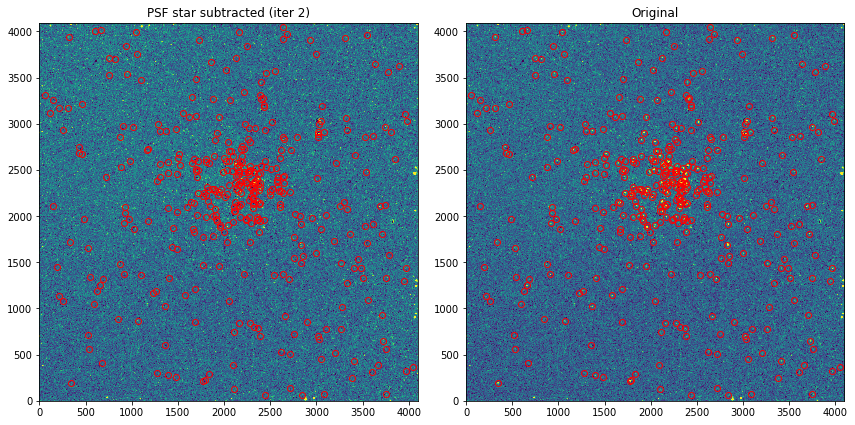

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=False, sharey=False, gridspec_kw=None)
yvu.norm_imshow(axs[0], data - data_staronly, zscale=True)
yvu.norm_imshow(axs[1], data, zscale=True)
# axs[1].imshow(data / (data - data_staronly), vmin=-2, vmax=+2)
axs[0].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
axs[1].plot(phot["xcenter"], phot["ycenter"], 'ro', mfc='none')
plt.tight_layout()

axs[0].set_title("PSF star subtracted (iter 2)")
axs[1].set_title("Original")

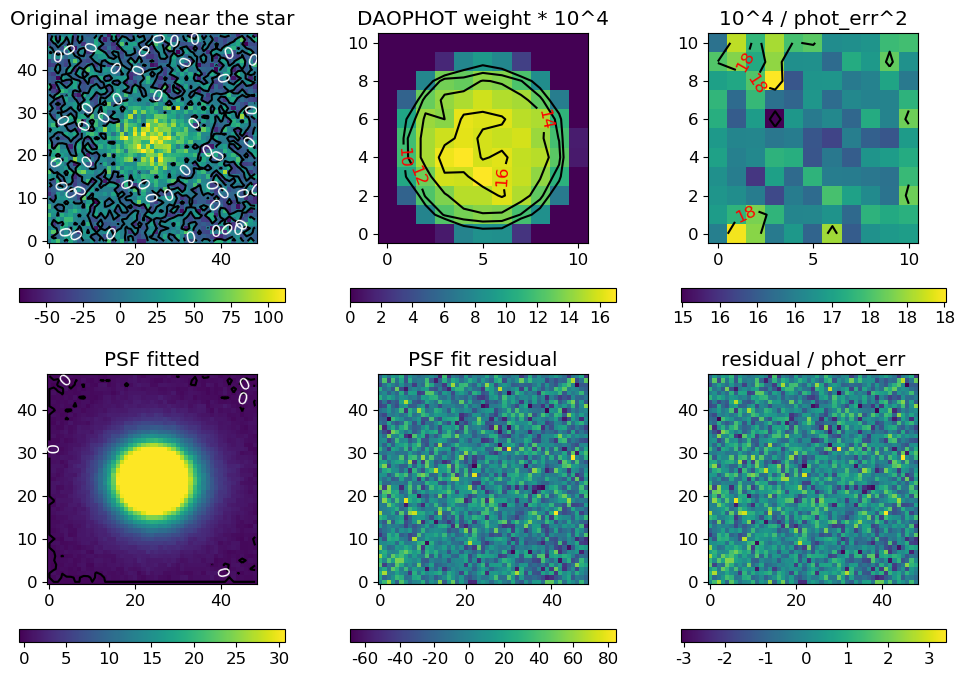

In [35]:
model_fitted = fit(xx_sub, yy_sub)
scut_skysub = scut.data - sky
scut_err = Cutout2D(err, position=pos_fit, size=psf_size).data
residual = scut_skysub - model_fitted

fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=False, sharey=False, gridspec_kw=None)
axo = axs[0, 0]  # original
axd = axs[0, 1]  # DAOphot weight
d = 1.e+4 * astropy_weight**2
axp = axs[0, 2]  # phot error
p = 1.e+4 / fcut_err**2
axf = axs[1, 0]  # fit
axr = axs[1, 1]  # residual
ax1 = axs[1, 2]  # residual / phot err

im = yvu.norm_imshow(axo, scut_skysub, zscale=True)
cs = axo.contour(scut_skysub, colors='k', levels=np.arange(0, 1000, 200))
axo.clabel(cs, inline=1, colors='w', fmt="%.0f")
axo.set_title("Original image near the star")
yvu.colorbaring(fig, axo, im)

im = yvu.norm_imshow(axd, d, zscale=True)
cs = axd.contour(d, colors='k', levels=np.arange(d.max() - 7, d.max()+3, 2))
axd.clabel(cs, inline=1, colors='r', fmt="%.0f")
axd.set_title("DAOPHOT weight * 10^4")
yvu.colorbaring(fig, axd, im)

im = yvu.norm_imshow(axp, p, zscale=True)
cs = axp.contour(p, colors='k', levels=np.arange(p.max() - 7, p.max()+3, 2))
axp.clabel(cs, inline=1, colors='r', fmt="%.0f")
axp.set_title("10^4 / phot_err^2")
yvu.colorbaring(fig, axp, im)

im = yvu.norm_imshow(axf, model_fitted, zscale=True)
cs = axf.contour(model_fitted, colors='k', levels=np.arange(0, 1000, 200))
axf.clabel(cs, inline=1, colors='w', fmt="%.0f")
axf.set_title("PSF fitted")
yvu.colorbaring(fig, axf, im)

im = yvu.norm_imshow(axr, residual, zscale=True)
axr.set_title("PSF fit residual")
yvu.colorbaring(fig, axr, im)

im = yvu.norm_imshow(ax1, residual / scut_err, zscale=True)
ax1.set_title("residual / phot_err")
yvu.colorbaring(fig, ax1, im)

plt.tight_layout()

In [36]:
ccd_2 = ccd_1.copy()
ccd_2.data = data - data_staronly
ccd_2.uncertainty = None
ccd_2.header["PSFITER"] = 2
ccd_2 = yfu.CCDData_astype(ccd=ccd_2, dtype='float32')
ccd_2.write("tmp/SNUO_STX16803-M11-1-1-20190507-171622-V-60.0_CR_PSF_02.fits", overwrite=True)